In [98]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import emcee
import plotutils.runner as pr
import rates_tool.foreground as fg
import rates_tool.kde as kde
import rates_tool.rate as rt
import triangle as tri
import scipy.optimize as so
import scipy.stats as ss

Populating the interactive namespace from numpy and matplotlib


In [3]:
fore = fg.draw_snrs(5.5, 1000000)

In [72]:
reload(kde)
fore_kde = kde.KDE(fore)

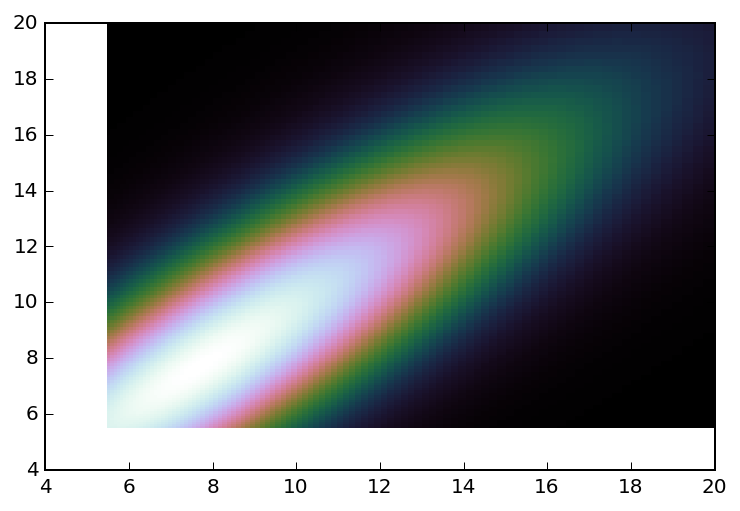

In [8]:
xs = exp(linspace(log(5.5), log(20), 100))
ys = exp(linspace(log(5.5), log(20), 100))
XS, YS = meshgrid(xs, ys)
log_ZS = fore_kde(column_stack((XS.flatten(), YS.flatten()))).reshape(XS.shape)
pcolormesh(XS, YS, exp(log_ZS))

In [51]:
bgs = [np.loadtxt('../../Hamlet/data/10Multiple/Triggers1_seed33244.txt')[:,2], np.loadtxt('../../Hamlet/data/10Multiple/Triggers2_seed33244.txt')[:,2]]

In [53]:
coincs = loadtxt('../../Hamlet/data/10Multiple/CoincTriggers_seed33244.txt', skiprows=1)[:,[2,5]]

In [93]:
reload(rt)
ratepost = rt.RatePosterior(bgs, fore, coincs)

In [96]:
pbest = so.fmin_powell(lambda x: -ratepost(x), zeros(2))

Optimization terminated successfully.
         Current function value: -23.448405
         Iterations: 3
         Function evaluations: 80


In [97]:
sampler = emcee.EnsembleSampler(128, 2, ratepost)
runner = pr.EnsembleSamplerRunner(sampler, pbest + 1e-3*randn(128, 2))
runner.run_to_neff(128)

Accumulated  128  ensembles, acceptance rate is  0.735229492188
Accumulated  256  ensembles, acceptance rate is  0.716247558594
Accumulated  384  ensembles, acceptance rate is  0.714782714844
Equivalent to  15  effective ensembles
Accumulated  512  ensembles, acceptance rate is  0.709747314453
Equivalent to  13  effective ensembles
Accumulated  640  ensembles, acceptance rate is  0.708483886719
Equivalent to  24  effective ensembles
Accumulated  768  ensembles, acceptance rate is  0.707356770833
Equivalent to  22  effective ensembles
Accumulated  896  ensembles, acceptance rate is  0.705950055804
Equivalent to  29  effective ensembles
Accumulated  1024  ensembles, acceptance rate is  0.704544067383
Equivalent to  39  effective ensembles
Accumulated  1152  ensembles, acceptance rate is  0.705362955729
Equivalent to  42  effective ensembles
Accumulated  1280  ensembles, acceptance rate is  0.704455566406
Equivalent to  47  effective ensembles
Accumulated  1408  ensembles, acceptance rate

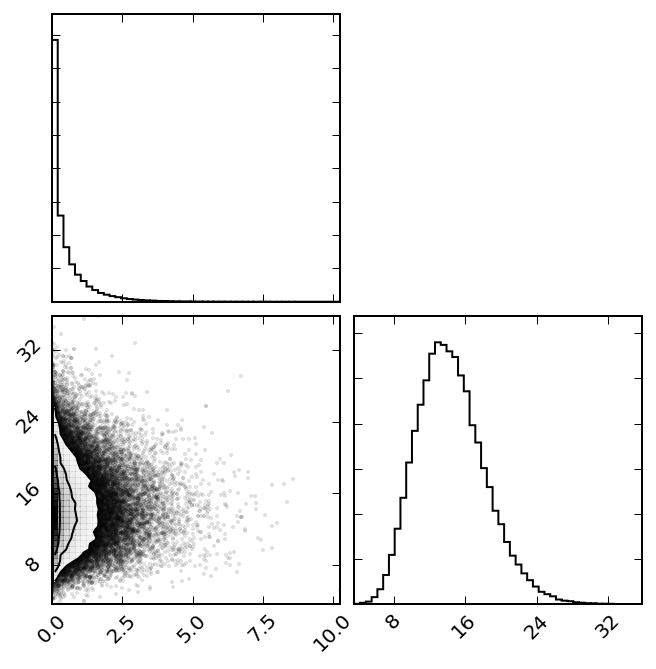

In [101]:
tri.corner(exp(runner.burnedin_chain.reshape((-1, 2))))
None